# Tutorial 4: CTDE Training

**Goal:** Train coordinator-level policies using Centralized Training with Decentralized Execution (CTDE).

**Time:** ~10 minutes

---

## CTDE in HERON

HERON's hierarchical architecture naturally supports CTDE:

```
Training (Centralized)              Execution (Decentralized)
                                    
SystemAgent                         SystemAgent
  |                                   |
  +-- Coordinator (policy)            +-- Coordinator (policy)
  |     +-- Device 1                  |     +-- Device 1
  |     +-- Device 2                  |     +-- Device 2
  |                                   |
  +-- Coordinator (policy)            +-- Coordinator (policy)
        +-- Device 3                        +-- Device 3

env.step(actions)                   env.run_event_driven()
All agents step together            Agents tick independently
Shared reward signal                Local observations only
```

**Key Pattern:**
- Coordinators own policies and compute joint actions
- `VerticalProtocol` decomposes joint actions into per-device actions
- Devices apply individual actions and report rewards

## Step 1: Build Agent Hierarchy

We use the production `PowerGridAgent`, `Generator`, and `ESS` classes with `VerticalProtocol` for action distribution.

In [17]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from typing import Any, Dict, List, Optional
from dataclasses import dataclass, field

# HERON imports
from heron.agents.system_agent import SystemAgent
from heron.core.observation import Observation
from heron.core.action import Action
from heron.core.policies import Policy, obs_to_vector, vector_to_action
from heron.protocols.vertical import VerticalProtocol
from heron.scheduling import TickConfig, JitterType
from heron.scheduling.analysis import EventAnalyzer

# PowerGrid imports
from powergrid.agents import PowerGridAgent, Generator, ESS
from powergrid.envs import HierarchicalMicrogridEnv

print("Imports ready!")

Imports ready!


In [18]:
def create_microgrid(mg_id: str, num_gen: int = 1, num_ess: int = 1) -> PowerGridAgent:
    """Create a microgrid coordinator with generators and ESS devices."""
    subordinates = {}

    for i in range(num_gen):
        gen_id = f"{mg_id}_Gen{i + 1}"
        subordinates[gen_id] = Generator(
            agent_id=gen_id,
            bus=f"{mg_id}_bus",
            p_min_MW=0.1,
            p_max_MW=1.0 + 0.5 * i,
            cost_curve_coefs=(0.01 + 0.005 * i, 0.4 + 0.1 * i, 0.0),
        )

    for i in range(num_ess):
        ess_id = f"{mg_id}_ESS{i + 1}"
        subordinates[ess_id] = ESS(
            agent_id=ess_id,
            bus=f"{mg_id}_bus",
            capacity_MWh=2.0 + i,
            p_min_MW=-0.5 - 0.1 * i,
            p_max_MW=0.5 + 0.1 * i,
            degr_cost_per_MWh=0.1,
        )

    # VerticalProtocol decomposes coordinator's joint action into per-device actions
    return PowerGridAgent(
        agent_id=mg_id,
        subordinates=subordinates,
        protocol=VerticalProtocol(),
    )


# Build 3-microgrid hierarchy
mg1 = create_microgrid("MG1", num_gen=1, num_ess=1)
mg2 = create_microgrid("MG2", num_gen=2, num_ess=1)
mg3 = create_microgrid("MG3", num_gen=1, num_ess=2)

system_agent = SystemAgent(
    agent_id="system_agent",
    subordinates={"MG1": mg1, "MG2": mg2, "MG3": mg3},
)

print("=== Agent Hierarchy ===")
print(f"L3 SystemAgent: {system_agent.agent_id}")
for mg_id, mg in system_agent.subordinates.items():
    devices = list(mg.subordinates.keys())
    print(f"  L2 {mg_id}: {devices} (protocol={type(mg.protocol).__name__})")

=== Agent Hierarchy ===
L3 SystemAgent: system_agent
  L2 MG1: ['MG1_Gen1', 'MG1_ESS1'] (protocol=VerticalProtocol)
  L2 MG2: ['MG2_Gen1', 'MG2_Gen2', 'MG2_ESS1'] (protocol=VerticalProtocol)
  L2 MG3: ['MG3_Gen1', 'MG3_ESS1', 'MG3_ESS2'] (protocol=VerticalProtocol)


## Step 2: Create Environment

`HierarchicalMicrogridEnv` connects the agent hierarchy to PandaPower simulation.

In [19]:
# Dataset path (relative to this notebook)
dataset_path = os.path.abspath(os.path.join(
    os.path.dirname('__file__'), '..', 'powergrid', 'data.pkl'
))

env = HierarchicalMicrogridEnv(
    system_agent=system_agent,
    dataset_path=dataset_path,
    episode_steps=24,
    dt=1.0,
)

print(f"Registered agents ({len(env.registered_agents)}):")
for aid in sorted(env.registered_agents.keys()):
    agent = env.registered_agents[aid]
    print(f"  {aid}: {type(agent).__name__}")

Registered agents (13):
  MG1: PowerGridAgent
  MG1_ESS1: ESS
  MG1_Gen1: Generator
  MG2: PowerGridAgent
  MG2_ESS1: ESS
  MG2_Gen1: Generator
  MG2_Gen2: Generator
  MG3: PowerGridAgent
  MG3_ESS1: ESS
  MG3_ESS2: ESS
  MG3_Gen1: Generator
  proxy_agent: ProxyAgent
  system_agent: SystemAgent


## Step 3: Define Coordinator Policy

Each coordinator gets an actor-critic neural network.
The policy uses HERON's `Policy` base class with `@obs_to_vector` and `@vector_to_action` decorators
for automatic observation extraction and action conversion.

In [20]:
class SimpleMLP:
    """Simple MLP for value function approximation."""

    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int, seed: int = 42):
        np.random.seed(seed)
        self.W1 = np.random.randn(input_dim, hidden_dim) * np.sqrt(2.0 / input_dim)
        self.b1 = np.zeros(hidden_dim)
        self.W2 = np.random.randn(hidden_dim, output_dim) * np.sqrt(2.0 / hidden_dim)
        self.b2 = np.zeros(output_dim)

    def forward(self, x: np.ndarray) -> np.ndarray:
        h = np.maximum(0, x @ self.W1 + self.b1)  # ReLU
        return np.tanh(h @ self.W2 + self.b2)

    def update(self, x: np.ndarray, target: np.ndarray, lr: float = 0.01) -> None:
        h = np.maximum(0, x @ self.W1 + self.b1)
        out = np.tanh(h @ self.W2 + self.b2)
        d_out = (out - target) * (1 - out**2)
        self.W2 -= lr * np.outer(h, d_out)
        self.b2 -= lr * d_out
        d_h = d_out @ self.W2.T
        d_h[h <= 0] = 0
        self.W1 -= lr * np.outer(x, d_h)
        self.b1 -= lr * d_h


class ActorMLP(SimpleMLP):
    """Actor network with policy gradient updates."""

    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int, seed: int = 42):
        super().__init__(input_dim, hidden_dim, output_dim, seed)
        self.W2 = np.random.randn(hidden_dim, output_dim) * 0.1
        self.b2 = np.zeros(output_dim)

    def update(self, x: np.ndarray, action_taken: np.ndarray, advantage: float, lr: float = 0.01) -> None:
        h = np.maximum(0, x @ self.W1 + self.b1)
        current_action = np.tanh(h @ self.W2 + self.b2)
        error = current_action - action_taken
        grad_scale = advantage * (1 - current_action**2)
        d_W2 = np.outer(h, grad_scale * error)
        d_b2 = grad_scale * error
        d_h = (grad_scale * error) @ self.W2.T
        d_h[h <= 0] = 0
        self.W2 -= lr * d_W2
        self.b2 -= lr * d_b2.flatten()
        self.W1 -= lr * np.outer(x, d_h)
        self.b1 -= lr * d_h.flatten()


class CoordinatorNeuralPolicy(Policy):
    """Neural policy for coordinator (microgrid) that computes joint action.
    
    Uses HERON's Policy interface with decorators:
    - @obs_to_vector: Converts Observation -> numpy array
    - @vector_to_action: Converts numpy array -> Action object
    """

    def __init__(self, obs_dim: int, action_dim: int, hidden_dim: int = 32, seed: int = 42):
        self.obs_dim = obs_dim
        self.action_dim = action_dim
        self.action_range = (-1.0, 1.0)
        self.actor = ActorMLP(obs_dim, hidden_dim, action_dim, seed)
        self.critic = SimpleMLP(obs_dim, hidden_dim, 1, seed + 1)
        self.noise_scale = 0.15

    def _normalize_obs(self, obs_vec: np.ndarray) -> np.ndarray:
        if len(obs_vec) > self.obs_dim:
            return obs_vec[:self.obs_dim]
        elif len(obs_vec) < self.obs_dim:
            return np.pad(obs_vec, (0, self.obs_dim - len(obs_vec)))
        return obs_vec

    @obs_to_vector
    @vector_to_action
    def forward(self, obs_vec: np.ndarray) -> np.ndarray:
        obs_vec = self._normalize_obs(obs_vec)
        action_mean = self.actor.forward(obs_vec)
        action_vec = action_mean + np.random.normal(0, self.noise_scale, self.action_dim)
        return np.clip(action_vec, -1.0, 1.0)

    @obs_to_vector
    def get_value(self, obs_vec: np.ndarray) -> float:
        obs_vec = self._normalize_obs(obs_vec)
        return float(self.critic.forward(obs_vec)[0])

    def update(self, obs: np.ndarray, action_taken: np.ndarray, advantage: float, lr: float = 0.01):
        self.actor.update(obs, action_taken, advantage, lr)

    def update_critic(self, obs: np.ndarray, target: float, lr: float = 0.01):
        self.critic.update(obs, np.array([target]), lr)

    def decay_noise(self, decay_rate: float = 0.995, min_noise: float = 0.05):
        self.noise_scale = max(min_noise, self.noise_scale * decay_rate)


print("Policy classes defined!")

Policy classes defined!


## Step 4: CTDE Training Loop

The training loop follows this flow each step:

```
1. Coordinator aggregates subordinate observations
2. Coordinator policy computes joint action
3. VerticalProtocol decomposes into per-device actions
4. env.step(device_actions) runs simulation
5. Device rewards are aggregated back to coordinator
6. Policy gradient update with advantage estimation
```

In [21]:
# Identify coordinators and their devices
coordinator_ids = []
coordinator_device_ids: Dict[str, List[str]] = {}

for aid, agent in env.registered_agents.items():
    if isinstance(agent, PowerGridAgent) and agent.subordinates:
        coordinator_ids.append(aid)
        coordinator_device_ids[aid] = list(agent.subordinates.keys())

# Reset to get initial observations and compute obs dimensions
obs, _ = env.reset(seed=0)

obs_dims_per_device: Dict[str, int] = {}
obs_dims_per_coordinator: Dict[str, int] = {}

for coord_id in coordinator_ids:
    total_dim = 0
    for sub_id in coordinator_device_ids[coord_id]:
        if sub_id in obs:
            sub_obs = obs[sub_id]
            dim = sub_obs.local_vector().shape[0] if isinstance(sub_obs, Observation) else len(np.asarray(sub_obs).flatten())
            dim = max(dim, 2)
            obs_dims_per_device[sub_id] = dim
            total_dim += dim
    obs_dims_per_coordinator[coord_id] = max(total_dim, 4)

# Create policies
coordinator_policies: Dict[str, CoordinatorNeuralPolicy] = {}

print("Coordinator policies:")
for i, coord_id in enumerate(coordinator_ids):
    obs_dim = obs_dims_per_coordinator[coord_id]
    action_dim = len(coordinator_device_ids[coord_id])
    coordinator_policies[coord_id] = CoordinatorNeuralPolicy(
        obs_dim=obs_dim, action_dim=action_dim, hidden_dim=32, seed=42 + i,
    )
    print(f"  {coord_id}: obs_dim={obs_dim}, action_dim={action_dim}, devices={coordinator_device_ids[coord_id]}")

Coordinator policies:
  MG1: obs_dim=7, action_dim=2, devices=['MG1_Gen1', 'MG1_ESS1']
  MG2: obs_dim=9, action_dim=3, devices=['MG2_Gen1', 'MG2_Gen2', 'MG2_ESS1']
  MG3: obs_dim=12, action_dim=3, devices=['MG3_Gen1', 'MG3_ESS1', 'MG3_ESS2']


In [22]:
# CTDE Training
num_episodes = 30
steps_per_episode = 24
gamma = 0.99
lr = 0.02

returns_history = []
mg_rewards_history = {cid: [] for cid in coordinator_ids}

print(f"Training {num_episodes} episodes x {steps_per_episode} steps...")
print(f"{'='*60}")
print(f"{'Ep':>4} | {'Return':>10} | {'MA(5)':>10} | {'MG1':>8} | {'MG2':>8} | {'MG3':>8}")
print(f"{'-'*60}")

for episode in range(num_episodes):
    obs, _ = env.reset(seed=episode)
    trajectories = {
        cid: {"obs": [], "actions": [], "rewards": []}
        for cid in coordinator_ids
    }
    episode_return = 0.0
    mg_episode_rewards = {cid: 0.0 for cid in coordinator_ids}

    for step in range(steps_per_episode):
        all_device_actions = {}

        for coord_id in coordinator_ids:
            sub_ids = coordinator_device_ids[coord_id]
            policy = coordinator_policies[coord_id]

            # 1. Aggregate subordinate observations into coordinator obs
            aggregated_obs = []
            for sub_id in sub_ids:
                sub_dim = obs_dims_per_device.get(sub_id, 4)
                obs_value = obs.get(sub_id)
                if obs_value is None:
                    aggregated_obs.append(np.zeros(sub_dim, dtype=np.float32))
                    continue
                obs_vec = obs_value.local_vector() if isinstance(obs_value, Observation) else np.asarray(obs_value, dtype=np.float32).flatten()
                if len(obs_vec) > sub_dim:
                    obs_vec = obs_vec[:sub_dim]
                elif len(obs_vec) < sub_dim:
                    obs_vec = np.pad(obs_vec, (0, sub_dim - len(obs_vec)))
                aggregated_obs.append(obs_vec)

            agg_vec = np.concatenate(aggregated_obs) if aggregated_obs else np.zeros(4)
            coord_observation = Observation(timestamp=step, local={"obs": agg_vec})

            # 2. Coordinator policy computes joint action
            coord_action = policy.forward(coord_observation)

            trajectories[coord_id]["obs"].append(agg_vec.copy())
            trajectories[coord_id]["actions"].append(coord_action.c.copy())

            # 3. VerticalProtocol decomposes into per-device actions
            coord_agent = env.registered_agents.get(coord_id)
            if coord_agent and coord_agent.protocol:
                _, distributed_actions = coord_agent.protocol.coordinate(
                    coordinator_state=coord_agent.state,
                    coordinator_action=coord_action,
                    info_for_subordinates={sid: obs.get(sid) for sid in sub_ids},
                )
                for sub_id, sub_action in distributed_actions.items():
                    if sub_action is not None:
                        action_obj = Action()
                        action_obj.set_specs(dim_c=1, range=(np.array([-1.0]), np.array([1.0])))
                        if isinstance(sub_action, np.ndarray):
                            action_obj.set_values(c=sub_action.flatten()[:1])
                        else:
                            action_obj.set_values(c=np.array([float(sub_action)]))
                        all_device_actions[sub_id] = action_obj

        # 4. Step environment with device actions
        obs, rewards, terminated, _, info = env.step(all_device_actions)

        # 5. Aggregate device rewards to coordinators
        for coord_id in coordinator_ids:
            coord_reward = sum(rewards.get(sid, 0.0) for sid in coordinator_device_ids[coord_id])
            trajectories[coord_id]["rewards"].append(coord_reward)
            episode_return += coord_reward
            mg_episode_rewards[coord_id] += coord_reward

        if terminated.get("__all__", False):
            break

    # 6. Policy gradient update with advantage estimation
    for coord_id, traj in trajectories.items():
        if not traj["rewards"]:
            continue
        policy = coordinator_policies[coord_id]

        # Compute discounted returns
        returns = []
        G = 0
        for r in reversed(traj["rewards"]):
            G = r + gamma * G
            returns.insert(0, G)
        returns = np.array(returns)

        # Update actor and critic
        for t in range(len(traj["obs"])):
            obs_t = traj["obs"][t]
            baseline = policy.get_value(Observation(timestamp=t, local={"obs": obs_t}))
            advantage = returns[t] - baseline
            policy.update(obs_t, traj["actions"][t], advantage, lr=lr)
            policy.update_critic(obs_t, returns[t], lr=lr)

        policy.decay_noise()

    # Track progress
    returns_history.append(episode_return)
    for cid in coordinator_ids:
        mg_rewards_history[cid].append(mg_episode_rewards[cid])

    # Print progress every 5 episodes
    if (episode + 1) % 5 == 0:
        ma = np.mean(returns_history[-5:])
        mg_str = " | ".join(f"{mg_episode_rewards[cid]:8.2f}" for cid in coordinator_ids)
        print(f"{episode+1:4d} | {episode_return:10.2f} | {ma:10.2f} | {mg_str}")

print(f"{'='*60}")
print(f"Training complete!")
print(f"  Initial return (first 5): {np.mean(returns_history[:5]):.2f}")
print(f"  Final return (last 5):    {np.mean(returns_history[-5:]):.2f}")

Training 30 episodes x 24 steps...
  Ep |     Return |      MA(5) |      MG1 |      MG2 |      MG3
------------------------------------------------------------
[VectorDecomposition] [0.3327 0.1524] -> [('MG1_Gen1', '[0.3327]'), ('MG1_ESS1', '[0.1524]')]
[VectorDecomposition] [0.1791 0.2436 0.1577] -> [('MG2_Gen1', '[0.1791]'), ('MG2_Gen2', '[0.2436]'), ('MG2_ESS1', '[0.1577]')]
[VectorDecomposition] [ 0.0221  0.0988 -0.3052] -> [('MG3_Gen1', '[0.0221]'), ('MG3_ESS1', '[0.0988]'), ('MG3_ESS2', '[-0.3052]')]
[VectorDecomposition] [0.0638 0.2644] -> [('MG1_Gen1', '[0.0638]'), ('MG1_ESS1', '[0.2644]')]
[VectorDecomposition] [0.2324 0.3081 0.0488] -> [('MG2_Gen1', '[0.2324]'), ('MG2_Gen2', '[0.3081]'), ('MG2_ESS1', '[0.0488]')]
[VectorDecomposition] [ 0.1895  0.0366 -0.2041] -> [('MG3_Gen1', '[0.1895]'), ('MG3_ESS1', '[0.0366]'), ('MG3_ESS2', '[-0.2041]')]
[VectorDecomposition] [0.3054 0.2381] -> [('MG1_Gen1', '[0.3054]'), ('MG1_ESS1', '[0.2381]')]
[VectorDecomposition] [ 0.2676 -0.0255 -0.

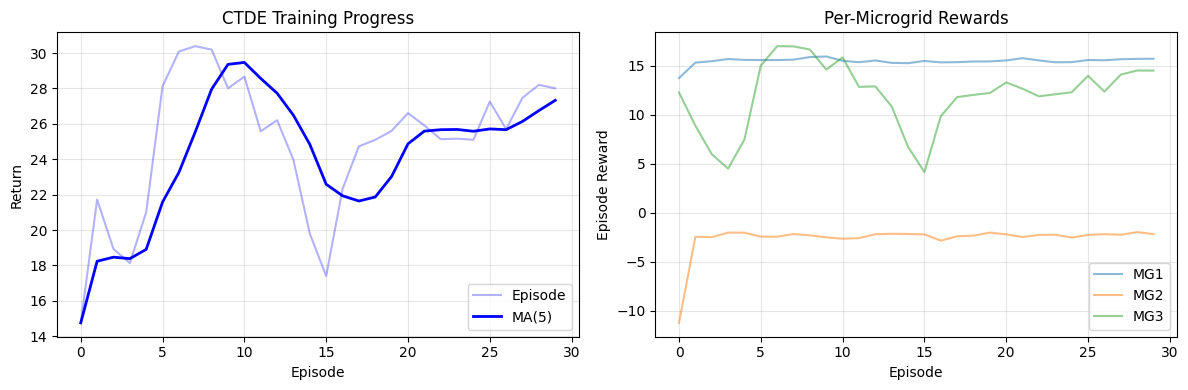

In [23]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Episode returns
axes[0].plot(returns_history, 'b-', alpha=0.3, label='Episode')
window = 5
if len(returns_history) >= window:
    ma = [np.mean(returns_history[max(0,i-window+1):i+1]) for i in range(len(returns_history))]
    axes[0].plot(ma, 'b-', linewidth=2, label=f'MA({window})')
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Return')
axes[0].set_title('CTDE Training Progress')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Per-microgrid rewards
colors = ['tab:blue', 'tab:orange', 'tab:green']
for i, (cid, rewards) in enumerate(mg_rewards_history.items()):
    axes[1].plot(rewards, color=colors[i % len(colors)], alpha=0.5, label=cid)
axes[1].set_xlabel('Episode')
axes[1].set_ylabel('Episode Reward')
axes[1].set_title('Per-Microgrid Rewards')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 5: Event-Driven Evaluation

After training in synchronous mode, we evaluate with event-driven execution.
This tests policy robustness under realistic timing (jitter, delays, heterogeneous tick rates).

In [24]:
# Attach trained policies to coordinators
for coord_id, policy in coordinator_policies.items():
    agent = env.registered_agents.get(coord_id)
    if agent is not None:
        agent.policy = policy

# Configure realistic timing for event-driven execution
system_tick_config = TickConfig.with_jitter(
    tick_interval=30.0, obs_delay=0.3, act_delay=0.5, msg_delay=0.2,
    jitter_type=JitterType.GAUSSIAN, jitter_ratio=0.1, seed=41,
)
coordinator_tick_config = TickConfig.with_jitter(
    tick_interval=10.0, obs_delay=0.2, act_delay=0.3, msg_delay=0.15,
    jitter_type=JitterType.GAUSSIAN, jitter_ratio=0.1, seed=43,
)
field_tick_config = TickConfig.with_jitter(
    tick_interval=5.0, obs_delay=0.1, act_delay=0.2, msg_delay=0.1,
    jitter_type=JitterType.GAUSSIAN, jitter_ratio=0.1, seed=42,
)

# Apply tick configs to agents
for agent_id, agent in env.registered_agents.items():
    if agent_id == "system_agent":
        agent.tick_config = system_tick_config
    elif isinstance(agent, PowerGridAgent):
        agent.tick_config = coordinator_tick_config
        for sub_agent in agent.subordinates.values():
            sub_agent.tick_config = field_tick_config
    elif hasattr(agent, 'tick_config') and agent_id != "proxy_agent":
        agent.tick_config = field_tick_config

# Update scheduler's cached tick configs
for agent_id, agent in env.registered_agents.items():
    if hasattr(agent, 'tick_config'):
        env.scheduler._agent_tick_configs[agent_id] = agent.tick_config

# Reset and run event-driven
env.reset(seed=100)
event_analyzer = EventAnalyzer(verbose=False)

print("Running event-driven evaluation (t_end=300.0)...")
result = env.run_event_driven(event_analyzer=event_analyzer, t_end=300.0)

print(f"\nResults:")
print(f"  Events processed: {result.num_events}")
print(f"  Duration: {result.duration:.1f}s")
print(f"  Observations: {event_analyzer.observation_count}")
print(f"  State updates: {event_analyzer.state_update_count}")
print(f"  Action results: {event_analyzer.action_result_count}")

# Event type breakdown
event_counts = result.get_event_counts()
print(f"\nEvent breakdown:")
for etype, count in event_counts.items():
    print(f"  {etype.value}: {count}")

Running event-driven evaluation (t_end=300.0)...
SystemAgent(id=system_agent, coordinators=3, protocol=None) doesn't act iself, becase there's no action policy
using proxy agent message delivery handler
[VectorDecomposition] [-0.2398  0.0934  0.2026] -> [('MG3_Gen1', '[-0.2398]'), ('MG3_ESS1', '[0.0934]'), ('MG3_ESS2', '[0.2026]')]
using proxy agent message delivery handler
[VectorDecomposition] [0.0761 0.3496] -> [('MG1_Gen1', '[0.0761]'), ('MG1_ESS1', '[0.3496]')]
using proxy agent message delivery handler
[VectorDecomposition] [-0.5727 -0.6432 -0.7023] -> [('MG2_Gen1', '[-0.5727]'), ('MG2_Gen2', '[-0.6432]'), ('MG2_ESS1', '[-0.7023]')]
using proxy agent message delivery handler
using proxy agent message delivery handler
using proxy agent message delivery handler
Received tick result from MG3_ESS1: {'reward': 0.8190407354850322, 'terminated': False, 'truncated': False, 'info': {}}
using proxy agent message delivery handler
using proxy agent message delivery handler
using proxy agent 

## Key Takeaways

### CTDE Architecture

| Component | Role |
|-----------|------|
| **Coordinator (L2)** | Owns the RL policy, computes joint actions |
| **VerticalProtocol** | Decomposes joint action into per-device actions |
| **Devices (L1)** | Apply individual actions, report rewards |
| **SystemAgent (L3)** | Orchestrates the step/tick cycle |

### Training Flow

```python
# 1. Coordinator aggregates device observations
agg_obs = concat([obs[device_id] for device_id in coordinator.subordinates])

# 2. Policy computes joint action
joint_action = policy.forward(agg_obs)  # Uses @obs_to_vector, @vector_to_action

# 3. Protocol distributes to devices
device_actions = protocol.coordinate(coordinator_state, joint_action, ...)

# 4. Environment steps all devices
obs, rewards, ... = env.step(device_actions)

# 5. Coordinator aggregates device rewards
coord_reward = sum(rewards[device_id] for device_id in coordinator.subordinates)
```

### Dual Execution Modes

- **Synchronous** (`env.step()`): Fast training, all agents step together
- **Event-driven** (`env.run_event_driven()`): Realistic testing with jitter and delays

---

**Next:** [05_event_driven_testing.ipynb](05_event_driven_testing.ipynb) — Deep dive into event-driven testing with timing analysis